# Unsupervised Learning (Matrix Factorization)

## Setup

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF 
import itertools
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

### Data Setup

In [2]:
# Read dataset and create training an testing datasets
training_set = pd.read_csv('../Data/train.csv')
training_set = training_set.drop(columns=["id"])

In [3]:
indexes = training_set["defects"].values

true_data = training_set[training_set["defects"].values == True]
false_data = training_set[training_set["defects"].values == False]

true_feature_data = true_data.drop(columns=["defects"])
false_feature_data = false_data.drop(columns=["defects"])

true_train_proportion = 0.5
false_train_proportion = true_train_proportion * len(true_feature_data) / len(false_feature_data)

true_X_train, true_X_validation, true_Y_train, true_Y_validation = train_test_split(true_feature_data, true_data["defects"], test_size=(1-true_train_proportion))
false_X_train, false_X_validation, false_Y_train, false_Y_validation = train_test_split(false_feature_data, false_data["defects"], test_size=(1-false_train_proportion))

X_train = pd.concat([true_X_train, false_X_train])
X_validation = pd.concat([true_X_validation, false_X_validation])
Y_train = pd.concat([true_Y_train, false_Y_train])
Y_validation = pd.concat([true_Y_validation, false_Y_validation])


## Model Creation

In [4]:
n_components=2
nmf_model = NMF(n_components=n_components)
nmf_model.fit(X_train) 
training_features = nmf_model.transform(X_train)

c:\Users\ivanm\.conda\envs\tf\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [5]:
def replace_set_labels(label_set, new_labels, old_labels):
    for i in range(len(old_labels)):
        label_set = [new_labels[i] if item == old_labels[i] else item for item in label_set]
    return label_set

def label_permute_compare(ytdf,yp,labels = [True, False]):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    
    perms = list(set(itertools.permutations(labels)))
    
    best_arr = []
    best_acc = -1
    
    options = np.unique(ytdf)

    for perm in perms:
        iter_arr = replace_set_labels(yp.copy(), perm, options)
            
        equal_values = iter_arr == ytdf.values
        iter_acc = np.count_nonzero(equal_values == True)/len(equal_values)
        
        if iter_acc > best_acc:
            best_arr = perm
            best_acc = iter_acc

    return [best_arr, best_acc]

In [6]:
training_predictions = pd.DataFrame(training_features).idxmax(axis=1)
extracted_labels, acc = label_permute_compare(Y_train, training_predictions)
print(extracted_labels, acc)

(False, True) 0.5005636489767603


In [7]:
def calculate_probabilities(predictions):

    feature_predictions = predictions.drop(columns="Prediction")

    max_values = feature_predictions.max(axis=1)
    min_values = feature_predictions.min(axis=1)

    probabilities = abs(max_values - min_values) / (abs(max_values) + abs(min_values))
    probabilities = abs(1 - probabilities - predictions["Prediction"])
    
    return probabilities



In [8]:
# Transform the TF-IDF: nmf_features
testing_features = nmf_model.transform(X_validation)

# Convert testing features into a DataFrame
testing_predictions = pd.DataFrame(testing_features, columns=extracted_labels)
testing_predictions.insert(2, "Prediction", testing_predictions.idxmax(axis=1), True)
testing_predictions.insert(3, "Probability", calculate_probabilities(testing_predictions), True)
# Print Predictions
testing_predictions


,False,True,Prediction,Probability
0,0.033306,0.0,False,0.0
1,0.463478,0.0,False,0.0
2,159.404017,0.0,False,0.0
3,22.505242,0.0,False,0.0
4,2.532225,0.0,False,0.0
...,...,...,...,...
78694,0.451558,0.0,False,0.0
78695,3.437721,0.0,False,0.0
78696,0.885064,0.0,False,0.0
78697,1.268243,0.0,False,0.0


In [9]:
conf_matrix = confusion_matrix(list(Y_validation), testing_predictions["Prediction"], labels=[0, 1])

recall_true = conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1])
precision_true = conf_matrix[1][1] / (conf_matrix[0][1] + conf_matrix[1][1])
F1_true = 2 * ( (precision_true * recall_true) / (precision_true + recall_true) )

correct_vals = conf_matrix[0][0] + conf_matrix[1][1]
incorrect_vals = conf_matrix[0][1] + conf_matrix[1][0]
accuracy = correct_vals / (correct_vals + incorrect_vals)

print("Correctly predicted labelss: ", correct_vals)
print("Incorrectly predicted labelss: ", incorrect_vals)
print("Model's accuracy: ", accuracy)
print("Model's recall: ", recall_true)
print("Model's precision: ", precision_true)
print("Model's F1 score: ", F1_true)

Correctly predicted labelss:  67147
Incorrectly predicted labelss:  11552
Model's accuracy:  0.8532128743694329
Model's recall:  0.0013007284079084287
Model's precision:  0.3
Model's F1 score:  0.002590226213089277


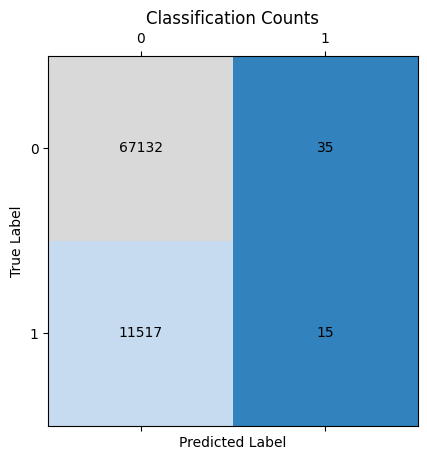

In [10]:
# Plot confusion Matrix
fig, ax = plt.subplots()
ax.matshow(conf_matrix, cmap='tab20c')

# Print classification counts within matrix boxes
for i in range(len(conf_matrix)):
   for j in range(len(conf_matrix[0])):
      c = conf_matrix[j, i]
      ax.text(i, j, str(c), va='center', ha='center')

# Set plot axis titles and show plot
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Classification Counts')
plt.show()

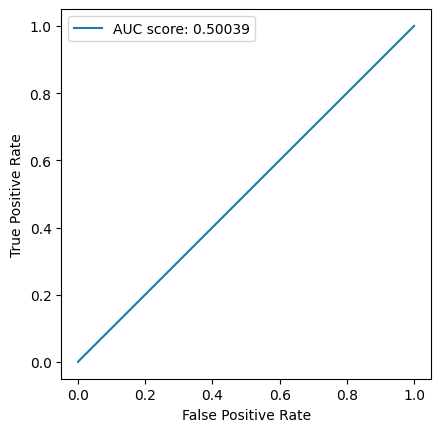

In [11]:
# Calculate scores for testing dataset
fpr, tpr, thresholds = roc_curve(list(Y_validation), testing_predictions["Prediction"])

# Calculate AUC score
auc_score = roc_auc_score(list(Y_validation), testing_predictions["Prediction"])

# Print ROC plot
plt.plot(fpr, tpr,)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(["AUC score: " + str(round(auc_score, 5))], loc="best")
plt.show()

In [12]:
n_components = 2
init_values = [None, 'random', 'nndsvd', 'nndsvda', 'nndsvdar']
solver_values = ['cd', 'mu']
beta_loss_values = ['kullback-leibler', 'frobenius']

model_results = []
models = []
best_score = 0
best_model_index = 0

i = 0

for init in init_values:
    for beta_loss in beta_loss_values:
        for solver in solver_values:
            if solver == 'cd' and not beta_loss == 'frobenius':
                continue
            
            model = NMF(n_components=n_components, init=init, solver=solver, beta_loss=beta_loss, random_state=5)
            training_features = model.fit_transform(X_train)
            training_predictions = pd.DataFrame(training_features).idxmax(axis=1)

            extracted_labels, _  = label_permute_compare(Y_train, training_predictions)

            # Transform the TF-IDF: nmf_features
            testing_features = model.transform(X_validation)

            # Convert testing features into a DataFrame
            testing_predictions = pd.DataFrame(testing_features, columns=extracted_labels)
            # Calculate prediction to highest feature in each row
            testing_predictions.insert(2, "Prediction", testing_predictions.idxmax(axis=1), True)

            results = testing_predictions[["Prediction"]].copy()
            results["True Label"] = list(Y_validation)
            results["Correct"] = results["True Label"] == results["Prediction"]

            conf_matrix = confusion_matrix(results["True Label"], results["Prediction"], labels=[True, False])
            
            recall_true = conf_matrix[0][0] / sum(conf_matrix[0])
            precision_true = conf_matrix[0][0] / sum(conf_matrix.T[0])
            F1_true = 2 * ( (precision_true * recall_true) / (precision_true + recall_true) )
            
            true_vals = conf_matrix[0][0] + conf_matrix[1][1]
            false_vals = conf_matrix[0][1] + conf_matrix[1][0]
            accuracy = true_vals / (true_vals + false_vals)

            model_results.append([init, beta_loss, solver, extracted_labels, accuracy, recall_true, precision_true, F1_true])
            models.append(model)

            score = recall_true * precision_true * accuracy
            if score > best_score:
                best_score = score
                best_model_index = i

            i += 1

model_results_df = pd.DataFrame(model_results, columns=["init", "beta_loss", "solver", "labels", "accuracy", "recall", "precision", "F1 score"])

model_results_df["acc*recall"] = model_results_df["accuracy"] * model_results_df["recall"]
model_results_df["acc*recall*recall"] = model_results_df["accuracy"] * model_results_df["recall"]* model_results_df["recall"]
model_results_df["acc*acc*recall"] = model_results_df["accuracy"] * model_results_df["accuracy"]* model_results_df["recall"]
model_results_df

c:\Users\ivanm\.conda\envs\tf\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\ivanm\.conda\envs\tf\lib\site-packages\sklearn\decomposition\_nmf.py:1561: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(
c:\Users\ivanm\.conda\envs\tf\lib\site-packages\sklearn\decomposition\_nmf.py:1561: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(
c:\Users\ivanm\.conda\envs\tf\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reache

,init,beta_loss,solver,labels,accuracy,recall,precision,F1 score,acc*recall,acc*recall*recall,acc*acc*recall
0,None,kullback-leibler,mu,"(True, False)",0.650402,0.605186,0.233107,0.336573,0.393614,0.238210,0.256007
1,None,frobenius,cd,"(False, True)",0.853213,0.001301,0.300000,0.002590,0.001110,0.000001,0.000947
2,None,frobenius,mu,"(False, True)",0.853200,0.001387,0.301887,0.002762,0.001184,0.000002,0.001010
3,random,kullback-leibler,mu,"(False, True)",0.752589,0.484131,0.292227,0.364461,0.364352,0.176394,0.274207
4,random,frobenius,cd,"(True, False)",0.146825,0.998613,0.146432,0.255412,0.146622,0.146418,0.021528
5,random,frobenius,mu,"(True, False)",0.146749,0.998613,0.146421,0.255395,0.146545,0.146342,0.021505
6,nndsvd,kullback-leibler,mu,"(True, False)",0.632295,0.618280,0.225163,0.330108,0.390935,0.241707,0.247186
7,nndsvd,frobenius,cd,"(False, True)",0.831815,0.164065,0.344752,0.222327,0.136472,0.022390,0.113519
8,nndsvd,frobenius,mu,"(False, True)",0.831815,0.164065,0.344752,0.222327,0.136472,0.022390,0.113519
9,nndsvda,kullback-leibler,mu,"(True, False)",0.650402,0.605186,0.233107,0.336573,0.393614,0.238210,0.256007


In [13]:
print("Best model: ", best_model_index)
print()
print(model_results_df.iloc[best_model_index])

Best model:  3

init                           random
beta_loss            kullback-leibler
solver                             mu
labels                  (False, True)
accuracy                     0.752589
recall                       0.484131
precision                    0.292227
F1 score                     0.364461
acc*recall                   0.364352
acc*recall*recall            0.176394
acc*acc*recall               0.274207
Name: 3, dtype: object


In [14]:
# Transform the TF-IDF: nmf_features
testing_features = models[best_model_index].transform(X_validation)

# Convert testing features into a DataFrame
testing_predictions = pd.DataFrame(testing_features, columns=model_results[best_model_index][3])
# Calculate prediction to highest feature in each row
testing_predictions.insert(2, "Prediction", testing_predictions.idxmax(axis=1), True)

conf_matrix = confusion_matrix(list(Y_validation), testing_predictions["Prediction"], labels=[0, 1])

recall_true = conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1])
precision_true = conf_matrix[1][1] / (conf_matrix[0][1] + conf_matrix[1][1])
F1_true = 2 * ( (precision_true * recall_true) / (precision_true + recall_true) )

correct_vals = conf_matrix[0][0] + conf_matrix[1][1]
incorrect_vals = conf_matrix[0][1] + conf_matrix[1][0]
accuracy = correct_vals / (correct_vals + incorrect_vals)

print("Correctly predicted labelss: ", correct_vals)
print("Incorrectly predicted labelss: ", incorrect_vals)
print("Model's accuracy: ", accuracy)
print("Model's recall: ", recall_true)
print("Model's precision: ", precision_true)
print("Model's F1 score: ", F1_true)

Correctly predicted labelss:  59228
Incorrectly predicted labelss:  19471
Model's accuracy:  0.7525889782589359
Model's recall:  0.48413111342351717
Model's precision:  0.29222716566343887
Model's F1 score:  0.3644612723177857


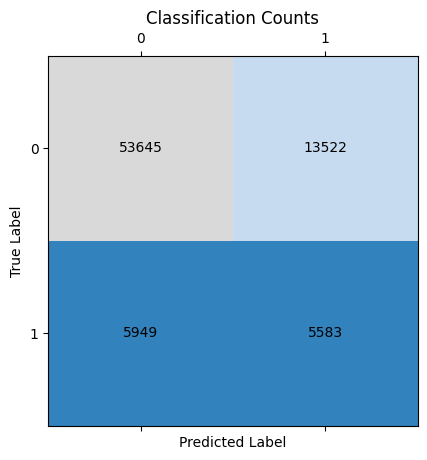

In [15]:
# Plot confusion Matrix
fig, ax = plt.subplots()
ax.matshow(conf_matrix, cmap='tab20c')

# Print classification counts within matrix boxes
for i in range(len(conf_matrix)):
   for j in range(len(conf_matrix[0])):
      c = conf_matrix[j, i]
      ax.text(i, j, str(c), va='center', ha='center')

# Set plot axis titles and show plot
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Classification Counts')
plt.show()

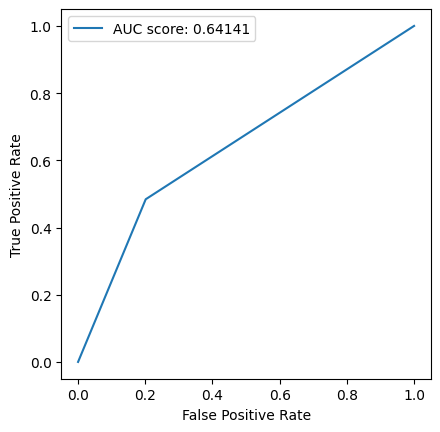

In [16]:
# Calculate scores for testing dataset
fpr, tpr, thresholds = roc_curve(list(Y_validation), testing_predictions["Prediction"])

# Calculate AUC score
auc_score = roc_auc_score(list(Y_validation), testing_predictions["Prediction"])

# Print ROC plot
plt.plot(fpr, tpr,)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(["AUC score: " + str(round(auc_score, 5))], loc="best")
plt.show()

## Kaggle Testing

In [17]:
testing_set = pd.read_csv('../Data/test.csv')
test = testing_set.drop(columns=["id"])

# Transform the TF-IDF: nmf_features
testing_features = models[best_model_index].transform(test)

# Convert testing features into a DataFrame
test_predictions = pd.DataFrame(testing_features, columns=model_results[best_model_index][3])
test_predictions.insert(2, "Prediction", test_predictions.idxmax(axis=1), True)
test_predictions.insert(3, "Probability", calculate_probabilities(test_predictions), True)
# Print Predictions
test_predictions["Prediction"].value_counts()


Prediction
False    49864
True     17978
Name: count, dtype: int64

In [18]:
results = pd.DataFrame(testing_set["id"].copy())
results["defects"] = test_predictions["Probability"]

print(results.head())
results.to_csv("../Data/results.csv", index=False)

       id   defects
0  101763  0.323534
1  101764  0.184710
2  101765  0.425805
3  101766  0.070055
4  101767  0.582527


## References

* [Binary Classification with a Software Defects Dataset](https://www.kaggle.com/competitions/playground-series-s3e23/code)
* [Software Metrics Glossary](http://www.mccabe.com/iq_research_metrics.htm)
* [Software Engineering | Halstead’s Software Metrics](https://www.geeksforgeeks.org/software-engineering-halsteads-software-metrics/)